In [1]:
!pip install torchvision

In [2]:
!pip install torch

In [8]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "cpu"

## Creation of artificial data

Data are created artificially with a mixed Gaussian distribution of two clusters, with specific means and standard deviations

In [4]:

def createData(numberSamplesPerClass = 2, mean1 = [6, 6], mean2 = [14, 14], stds1 = [3, 3], stds2 = [2, 1]):
    """
    Creates the data to be used for training, using a GMM distribution
    @param numberSamplesPerClass, the number of samples per class
    @param mean1, means for samples from the class 1
    @param mean2, means for samples from the class 2
    @param stds1, standard deviation for samples, class 1
    @param stds2, standard deviation for samples, class 2
    """
    means = torch.zeros(2, device = device)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1, device = device)
    means[0] = mean1[0]
    means[1] = mean1[1]
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2, device = device )
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]
    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]
    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)
    
    plt.scatter(samplesClass1[:, 0].cpu().detach().numpy(), samplesClass1[:, 1].cpu().detach().numpy(), marker = "x")  
    plt.scatter(samplesClass2[:, 0].cpu().detach().numpy(), samplesClass2[:, 1].cpu().detach().numpy())  
    
    #Create samples with bias
    samplesAllBias = torch.cat((samplesClass1Bias, samplesClass2Bias), 0)
    
    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1, device = device )
    targetsClass2 = -1 * torch.ones(numberSamplesPerClass, 1, device = device )
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)
    
    return (targetsAll, samplesAllBias)


'''
Creates data with gaussian distribution
'''
def createDataOneClass(means, covarianceMatrix, numberSamples):
    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))
    samples = torch.tensor(samples,  device = device )
    
    return samples

## Least squares implementation

In [5]:
def estimate_optimum_LS(t, M):
    """
    Estimate the optimum W with NO FORS
    param M: NumSamples x 1 matrix with target values (1 or -1)
    param t: NumSamples x NumDimensions 
    return w: array with optimum weights
    """
    M_pinv = torch.tensor(np.linalg.pinv(M.numpy()), device = device )
    w_opt = M_pinv.mm(t)
    return w_opt         


def forward(M, w):
    """
    Get model output, with NO FORS
    param M: dataset
    return t_estimated, with 1 or -1
    """
    y = M.mm(w)        
    y[y > 0] = 1
    y[y <= 0 ] = -1
    t_estimated = y
    return t_estimated

def evaluate_error(t, t_estimated):
    """
    Evaluate model error using the euclidian distance
    param t, real targets
    param t_estimated, estimated targets by the model
    """
    error = torch.norm(t - t_estimated, 1) / t.shape[0]

    return error

## Test the original least squares model

KeyboardInterrupt: 

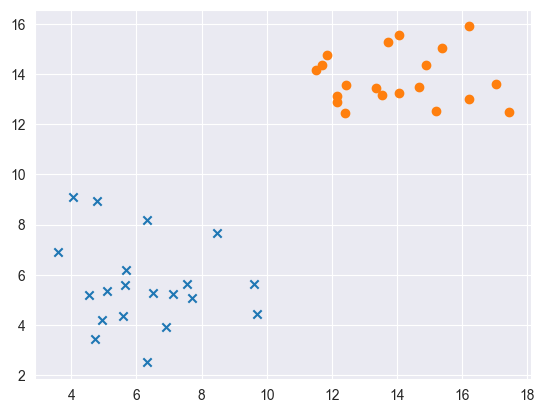

In [20]:
def plot_line(wOpt):
  wOpt = wOpt.cpu().detach()
  b = (-1*wOpt[0] / wOpt[2]).numpy()[0]
  m = (-1*wOpt[1] / wOpt[2]).numpy()[0]
  x = np.arange(0., 15., 0.01)
  y = m * x + b
  plt.plot(x, y)
  plt.show()
  
  
  

"""
Main function
"""
def main():
    (t, M) = createData(numberSamplesPerClass = 20)
    #estimate optimum model weights
    w_opt = estimate_optimum_LS(t, M)
    print("Pesos optimos \n ", w_opt)    
    #estimate targets for the training dataset
    t_estimated = forward(M, w_opt)
    #evaluates error using L1 distance
    error = evaluate_error(t, t_estimated)
    plot_line(w_opt)
    print("Training error: ", error)
    #Test error
    (t_test, M_test) = createData(numberSamplesPerClass = 20)
    #estimate targets for the training dataset
    t_estimated_test = forward(M_test, w_opt)
    #evaluates error using L1 distance
    error = evaluate_error(t_test, t_estimated_test)
    print("Test error: ", error)
    
main()
#(t, M) = createData(numberSamplesPerClass = 20, mean1 = [6, 6], mean2 = [14, 14], stds1 = [3, 3], stds2 = [2, 1])
    